In [ ]:
!pip install pprint ipywidgets pandas numpy matplotlib sklearn seaborn xgboost scipy yellowbrick statsmodels

# Gusto

Acute myocardial infarction (“heart attack”) is caused by the formation of a clot in oneof the coronary arteries that supply blood to the heart muscle. 

Acute MI is a major public health problem. Mortality is substantial in the period immediately after the event (and also during the years after surviving the initial  infarction). Some patients die before reaching the  hospital. Patients seen in hospitals are reported to have an average mortality within 30 days around 6–15%, with improvement over time. The risk of 30-day mortality strongly depends on various prognostic factors. In younger patients, risks are much lower than in older patients. Other patient demographics are also important (gender, length, weight), as well as the presence of risk factors (hypertension, diabetes, smoking, family history) and the history of previous cardiovascular events (previous MI, angina, stroke, bypass surgery). Relevant presenting characteristics includethe location of the infarction and the extent of ECG abnormalities. Very important is the acute state of the patients reflected by blood pressure,heart rate, and left ventricular function (e.g., presence of shock).

Aim of this study is to find predictors of 30-days mortality. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pprint import pprint
from time import sleep

#  load data
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator


import xgboost as xgb

from scipy.special import expit

from yellowbrick.classifier import ConfusionMatrix, ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:

df = pd.read_csv("./Gusto.csv")

# dummify smk categories
df['eversmk']= (df['smk']!=1).astype(int)
df['currentsmk']=(df['smk']==3).astype(int)
df.drop(["smk"], axis=1, inplace=True)
df

,day30,sex,age,a65,killip,sho,dia,hyp,hrt,ant,...,wei,htn,lip,pan,fam,ste,st4,ttr,eversmk,currentsmk
0,0,0,70.313,1,1,0,0,0,0,1,...,84.0,1,1,0,0,1,0,1,1,1
1,0,0,59.844,0,1,0,1,0,0,1,...,115.0,1,0,0,1,6,1,0,0,0
2,0,0,59.023,0,1,0,0,0,1,0,...,76.0,1,0,0,1,3,0,0,0,0
3,1,1,80.375,1,1,0,0,0,1,0,...,50.0,0,0,0,0,3,0,0,1,1
4,0,0,64.750,0,1,0,0,1,0,0,...,97.4,0,0,1,1,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,0,0,51.836,0,1,0,0,0,0,1,...,65.0,0,0,0,0,7,1,1,0,0
3657,0,0,51.836,0,1,0,1,0,0,1,...,72.1,0,0,1,0,7,1,1,1,1
3658,0,0,63.977,0,1,0,0,0,0,0,...,87.2,1,0,0,0,2,0,1,1,0
3659,0,1,59.758,0,1,0,0,0,0,0,...,57.8,0,0,0,0,6,1,1,1,1


In [3]:
# any null value?
bool(df.isnull().sum().sum())

False

In [4]:
# dropping useless/redundant columns
df.drop(["sho", "a65", "st4"], axis=1, inplace=True)
df.columns

Index(['day30', 'sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk'],
      dtype='object')

## Question 1

*Build a descriptive table, comparing patients deadversuspatients alive at 30 days. Insert also a column with the total population descriptive statistics.*




''

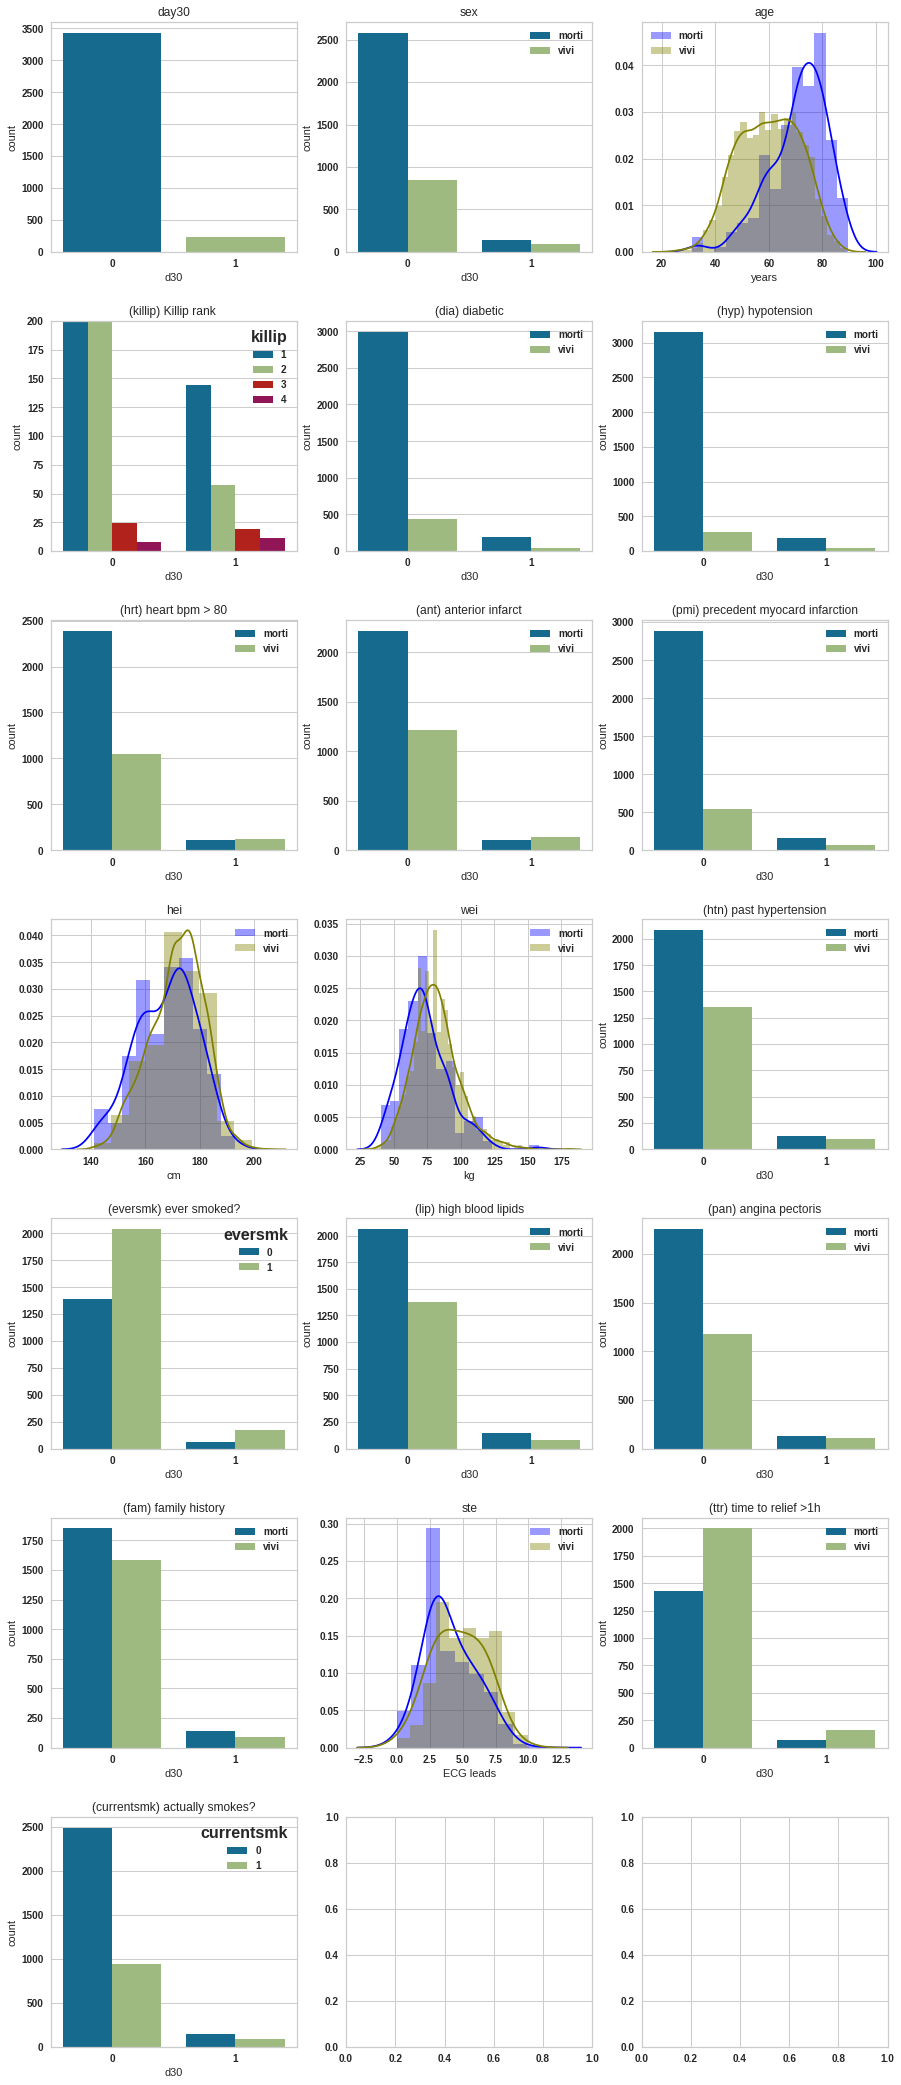

In [24]:
# quick overview
#print(df.describe())


fig, ((a11,a12,a13),
      (a21,a22,a23), 
      (a31,a32,a33),
      (a41,a42,a43),
      (a51,a52,a53),
      (a61,a62,a63),
      (a71,_  ,_  ))= plt.subplots(7,3, figsize=(15,15))


var = "day30"
#a11.hist(df[var], bins=2)
sns.countplot(x='day30',data=df, ax=a11)
a11.set_title(var)
a11.set_xlabel("d30")

sns.countplot(x='day30',hue='sex',data=df, ax=a12)
a12.set_title("sex")
a12.legend(["morti","vivi"])
a12.set_xlabel("d30")

sns.distplot( df.loc[df.day30==1, 'age'] , color="blue", label="0", ax=a13)
sns.distplot( df.loc[df.day30==0, 'age'] , color="olive", label="1", ax=a13)
a13.set_title("age")
a13.set_xlabel("years")
a13.legend(["morti","vivi"])

var = "killip"
a21.set_ylim([0,200])
sns.countplot(x='day30',hue='killip',data=df, ax=a21)
a21.set_title("(killip) Killip rank ")
a21.set_xlabel("d30")

sns.countplot(x='day30',hue='dia',data=df, ax=a22)
a22.set_title("(dia) diabetic")
a22.legend(["morti","vivi"])
a22.set_xlabel("d30")

sns.countplot(x='day30',hue='hyp',data=df, ax=a23)
a23.set_title("(hyp) hypotension")
a23.legend(["morti","vivi"])
a23.set_xlabel("d30")

sns.countplot(x='day30',hue='hrt',data=df, ax=a31)
a31.set_title("(hrt) heart bpm > 80")
a31.legend(["morti","vivi"])
a31.set_xlabel("d30")

sns.countplot(x='day30',hue='ant',data=df, ax=a32)
a32.set_title("(ant) anterior infarct")
a32.legend(["morti","vivi"])
a32.set_xlabel("d30")

sns.countplot(x='day30',hue='pmi',data=df, ax=a33)
a33.set_title("(pmi) precedent myocard infarction")
a33.legend(["morti","vivi"])
a33.set_xlabel("d30")

sns.distplot( df.loc[df.day30==1, 'hei'] , color="blue", label="0", ax=a41, bins=10)
sns.distplot( df.loc[df.day30==0, 'hei'] , color="olive", label="1", ax=a41, bins=10)
a41.set_title("hei")
a41.legend(["morti","vivi"])
a41.set_xlabel("cm")

sns.distplot( df.loc[df.day30==1, 'wei'] , color="blue", label="0", ax=a42)
sns.distplot( df.loc[df.day30==0, 'wei'] , color="olive", label="1", ax=a42)
a42.set_title("wei")
a42.legend(["morti","vivi"])
a42.set_xlabel("kg")

sns.countplot(x='day30',hue='htn',data=df, ax=a43)
a43.set_title("(htn) past hypertension")
a43.legend(["morti","vivi"])
a43.set_xlabel("d30")

sns.countplot(x='day30',hue='eversmk',data=df, ax=a51)
a51.set_title("(eversmk) ever smoked?")
a51.set_xlabel("d30")

sns.countplot(x='day30',hue='lip',data=df, ax=a52)
a52.set_title("(lip) high blood lipids")
a52.legend(["morti","vivi"])
a52.set_xlabel("d30")

sns.countplot(x='day30',hue='pan',data=df, ax=a53)
a53.set_title("(pan) angina pectoris")
a53.legend(["morti","vivi"])
a53.set_xlabel("d30")

sns.countplot(x='day30',hue='fam',data=df, ax=a61)
a61.set_title("(fam) family history")
a61.legend(["morti","vivi"])
a61.set_xlabel("d30")

sns.distplot( df.loc[df.day30==0, 'ste'] , color="blue",   label="0", ax=a62, kde_kws={"bw":1}, bins=10)
sns.distplot( df.loc[df.day30==1, 'ste'] , color="olive", label="1", ax=a62, kde_kws={"bw":1}, bins=10)
a62.set_title("ste")
a62.legend(["morti","vivi"])
a62.set_xlabel("ECG leads")

sns.countplot(x='day30',hue='ttr',data=df, ax=a63)
a63.set_title("(ttr) time to relief >1h")
a63.legend(["morti","vivi"])
a63.set_xlabel("d30")

sns.countplot(x='day30',hue='currentsmk',data=df, ax=a71)
a71.set_title("(currentsmk) actually smokes?")
a71.set_xlabel("d30")


plt.subplots_adjust(wspace = 0.2, hspace=0.3, top=2)

""

## check for multicollinearity

''

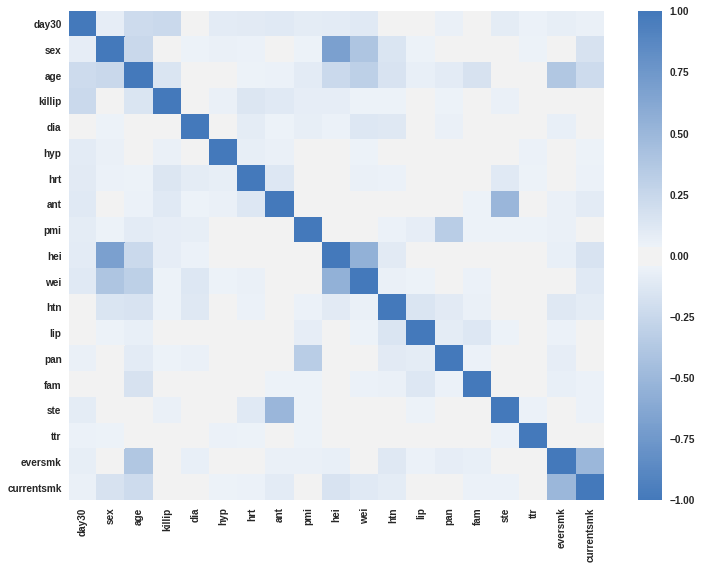

In [30]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(250, 250, n=256))
''

Analizzando la correlazione tra variabili, vediamo come alcune coppie di variabili siano correlate:

* age <-> hei <-> sex <-> wei  (prevedibilmente. valutare di unificarle?)
* age <-> smoke  (comprensibilmente)
* currentsmoke <-> eversmoke (è dura smettere)
* age <-> sex  (questa è da indagare)
* ste <-> ant  (anomalie ECG in caso di infarti precedenti?)
* pan <-> pmi  (angina e infarti al miocardio)

## Question 2

*Perform univariable logistic regression analyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable? How could you model alternatively the age effect?



# Univariate logistic regressions

*Perform univariable logistic regressionanalyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable?How could you model alternativelythe age effect?*



 ##############################    age    ############################## 



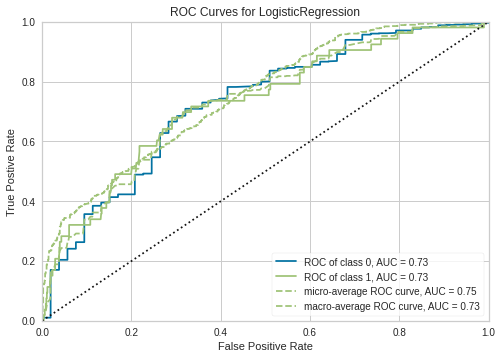



 ##############################    hei    ############################## 



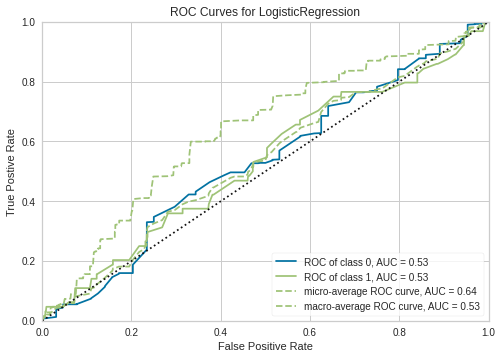



 ##############################    wei    ############################## 



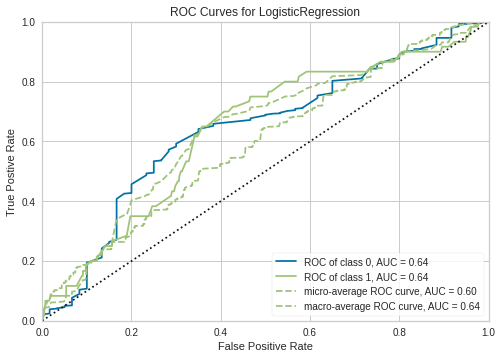



 ##############################    sex    ############################## 



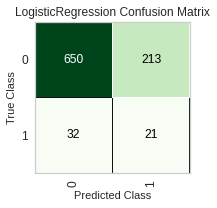



 ##############################    killip    ############################## 



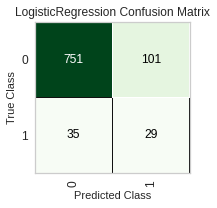



 ##############################    dia    ############################## 



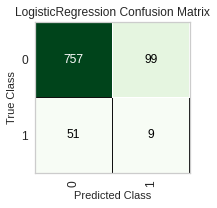



 ##############################    hyp    ############################## 



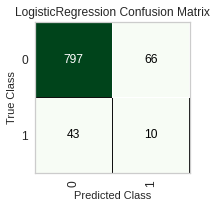



 ##############################    hrt    ############################## 



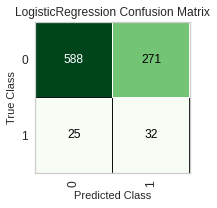



 ##############################    ant    ############################## 



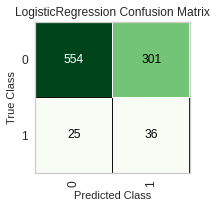



 ##############################    pmi    ############################## 



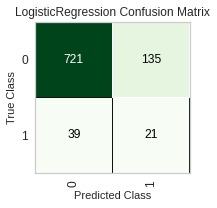



 ##############################    htn    ############################## 



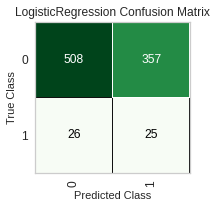



 ##############################    lip    ############################## 



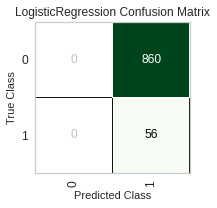



 ##############################    pan    ############################## 



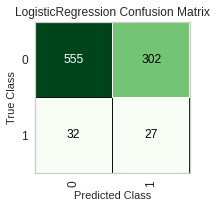



 ##############################    fam    ############################## 



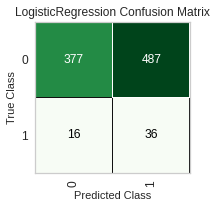



 ##############################    ste    ############################## 



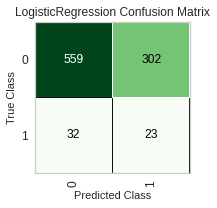



 ##############################    ttr    ############################## 



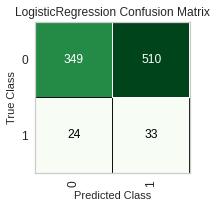



 ##############################    eversmk    ############################## 



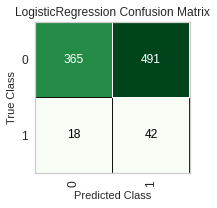



 ##############################    currentsmk    ############################## 



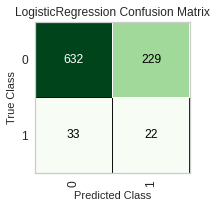

In [7]:

for col in ['age', 'hei', 'wei']:
    print("\n\n","#"*30,"  " ,str(col), "  ","#"*30,"\n")
    
    x_train, x_test, y_train, y_test = train_test_split(df[[col]], df['day30'])
    weight = 15
    fullModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
    fullModel.fit(x_train, y_train)
    rocauc = ROCAUC(fullModel)
    rocauc.score(x_test, y_test)  
    r = rocauc.poof()
    
    
for col in ['sex', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
        'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk']:
    
    print("\n\n","#"*30,"  " ,str(col), "  ","#"*30,"\n")
    
    x_train, x_test, y_train, y_test = train_test_split(df[[col]], df['day30'])
    weight = 15
    fullModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
    fullModel.fit(x_train, y_train)
    CM = ConfusionMatrix(fullModel, cmap="Greens", size=(200,200))
    CM.score(x_test, y_test)  
    r = CM.poof()
    
    

    

## Question 3

*Build  a multivariable  logistic  regression model  starting from the list of significant predictors at univariable analyses. Pay attention to multicollinearity (same variables recoded in different ways).* 

We'll compute a full model, then compute VIF  (Variance Inflation Factor) to estimate collinearity and select the covariates.

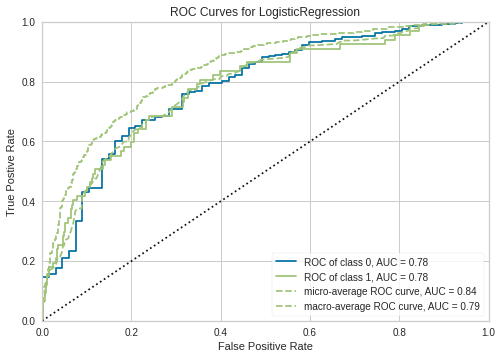

coefficients =
[('sex', -0.3870333557642268),
 ('age', 0.07681469881042673),
 ('killip', 0.9982148492031506),
 ('dia', -0.16007877459758185),
 ('hyp', 1.27878812793737),
 ('hrt', 0.8012874153402678),
 ('ant', 0.34028031729874897),
 ('pmi', 0.44616834801020167),
 ('hei', -0.03713589089809168),
 ('wei', -0.012453789213658324),
 ('htn', -0.13107556682033786),
 ('lip', -0.07538595895378027),
 ('pan', 0.37579794431650776),
 ('fam', -0.005911486732472932),
 ('ste', 0.09727848511659516),
 ('ttr', 0.3863528685790226),
 ('eversmk', -0.16026126646312205),
 ('currentsmk', 0.08058429449954298)]
'intercept: [-0.4311994]'


In [8]:

x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['day30'])
weight = 15
fullModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
fullModel.fit(x_train, y_train)
rocauc = ROCAUC(fullModel)
rocauc.score(x_test, y_test)  
r = rocauc.poof()

print("coefficients =")
pprint(list(zip(df.columns[1:],fullModel.coef_.tolist()[0])))
pprint("intercept: {}".format(fullModel.intercept_))


In [9]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[df.columns[1:]].values, i) for i in range(df[df.columns[1:]].shape[1])]
vif["features"] = df[df.columns[1:]].columns
vif

,VIF Factor,features
0,1.751590,sex
1,38.567540,age
2,8.581997,killip
3,1.222906,dia
4,1.125857,hyp
5,1.572605,hrt
6,2.196240,ant
7,1.395508,pmi
8,93.844782,hei
9,36.164083,wei


# removing multicollinear variables

* `age <-> hei <-> sex <-> wei`  (prevedibilmente)
* `age <-> smoke`  (comprensibilmente)
* `age <-> sex`  (questa è da indagare)
* `ste <-> ant`  (anomalie ECG in caso di infarti precedenti?)
* `pan <-> pmi`  (angina e infarti al miocardio)



* Removing: `'hei','wei','age'`, leaving `'sex'` and `'smoke'`
* Removing: `'pan'`, leaving `'pmi'`
* Removing: `'ste'`, leaving `'ant'`

### Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [10]:
# Feature Extraction with Recurrent Feature Extraction

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model,n_features_to_select=5, step=1)  
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True False  True False  True  True False  True False False False False
 False False False False False False]
Feature Ranking: [ 1  9  1 13  1  1  2  1 12 14  6  8  5 11  7  4  3 10]


In [11]:
# selected: 'sex','killip','hyp','ant','pmi'


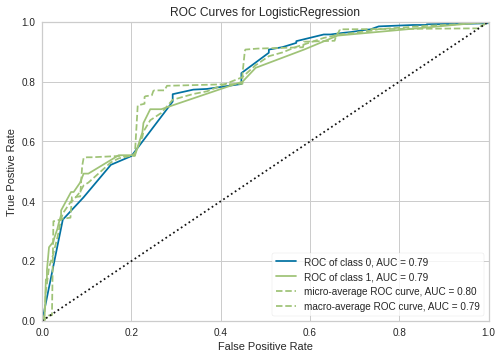

coefficients =
[('sex', 0.6829084938157525),
 ('killip', 0.9677898002078097),
 ('hyp', 0.694252887569354),
 ('ant', 0.887818120455538),
 ('pmi', 0.6325880523288333)]
'intercept: [-2.1298064]'


In [12]:
# pruned model

selectedCovar=['sex','killip','hyp','ant','pmi']


x_train, x_test, y_train, y_test = train_test_split(df[selectedCovar], df['day30'])
weight = 15
fullModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
fullModel.fit(x_train, y_train)
rocauc = ROCAUC(fullModel)
rocauc.score(x_test, y_test)  
r = rocauc.poof()

print("coefficients =")
pprint(list(zip(selectedCovar,fullModel.coef_.tolist()[0])))
pprint("intercept: {}".format(fullModel.intercept_))


In [13]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[selectedCovar].values, i) for i in range(df[selectedCovar].shape[1])]
vif["features"] = df[selectedCovar].columns
vif

,VIF Factor,features
0,1.311768,sex
1,2.188681,killip
2,1.105411,hyp
3,1.567508,ant
4,1.206123,pmi


VIF factor looks under control for all selected covariates.

## Question 4 

*Evaluate model performance in discrimination by means of the AUC under the ROC curve. Evaluate also model performance in terms of calibration.* 



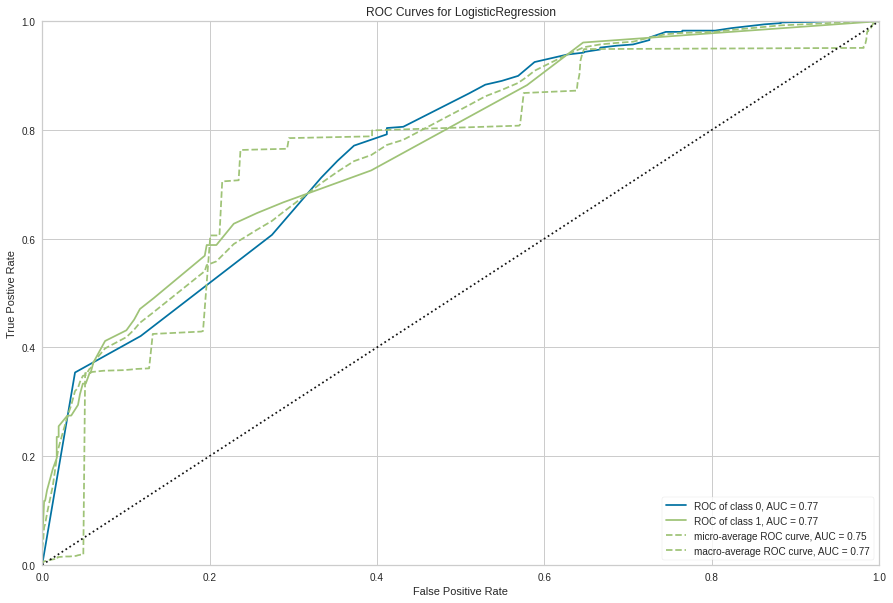

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df[selectedCovar], df['day30'])

weight = 15

prunedModel = LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})

prunedModel.fit(x_train, y_train)

rocauc = ROCAUC(prunedModel, size=(1080, 720))

rocauc.score(x_test, y_test)  
r = rocauc.poof()

5) Represent the estimated model by means of a nomogram (hint: R function nomogram {rms})

Niente nomogrammi su python, però ho fatto un widget interattivo.

In [15]:
# pruned model
font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


print("\n\n        ☠☠☠☠  Death Calculator  ☠☠☠☠ ")

# 'sex','killip','hyp','ant','pmi'

@interact(sex=["M","F"],   # sex
          killipClass=(1,4,1),  # killip
          hypotension=False, # hyp
          anteriorInfarctLocation=False, # ant          
          previousMiocardialInfarction=False, # pmi
         ) 

def pred( sex,   # sex
          killipClass,  # killip
          hypotension, # hyp
          anteriorInfarctLocation, # ant          
          previousMiocardialInfarction, # pmi
        ):
    
    sex= 1 if sex == 'F' else 0
    
    covariates = np.array([sex,   # sex
          killipClass,  # killip
          hypotension, # hyp
          anteriorInfarctLocation, # ant          
          previousMiocardialInfarction, # pmi
                          ])
    
    prediction = prunedModel.predict([covariates.astype(int)]), 
    prob =       prunedModel.predict_proba([covariates.astype(int)])

  
    #print("covariates:", covariates)
    print("p(p30)= {:.3}%".format(prob[0][1]*100))
    return





        ☠☠☠☠  Death Calculator  ☠☠☠☠ 


interactive(children=(Dropdown(description='sex', options=('M', 'F'), value='M'), IntSlider(value=2, descripti…

## Question 6

6) Internally validate the estimated model (hint: R function  validate {rms})



In [16]:

X = df[selectedCovar]
y = df[['day30']]

In [17]:
@interact(metric = metrics.SCORERS.keys())

def test(metric):
    clf = LogisticRegressionCV(cv=7, random_state=0, scoring = metric).fit(X, y)
    print("metric: {}, score = {:.4}".format(metric,clf.score(X, y)))

interactive(children=(Dropdown(description='metric', options=('explained_variance', 'r2', 'max_error', 'neg_me…

## Question 7

*Setting  aside  the  interpretability  of  the  model, are  you  able  to  find  a  machine learning algorithm that predicts the risk of event with a similar (or better) performance than the logistic model*

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['day30'])

xg_train = xgb.DMatrix(x_train, label=y_train)

n_folds = 5
early_stopping = 10

params = {'eta': 0.03, 
          'max_depth': 5, 
          'subsample': 0.7, 
          'colsample_bytree': 0.7, 
          'objective': 'binary:logistic',
          'seed': 99, 
          'silent': 1, 
          'eval_metric':'auc'}

cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)


[12:13:17] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:13:17] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:13:17] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


best metrics: 



In [31]:
cv.iloc[[-1]]

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
54,0.922294,0.003335,0.82311,0.035906


In [20]:
params = {'eta': 0.03, 
          'max_depth': 5, 
          'subsample': 0.7, 
          'colsample_bytree': 0.7, 
          'objective': 'binary:logistic',
          'seed': 99, 
          'silent': 1, 
          'eval_metric':'auc'}
    
xgbModel = xgb.XGBClassifier()
xgbModel.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[1:]], df['day30'])

xgtrain = xgb.DMatrix(x_train, label=y_train)

clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=1301)

xgb_param = clf.get_xgb_params()

#do cross validation
print ('Start cross validation')
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=1301)

print('Best number of trees = {}'.format(cvresult.shape[0]))
clf.set_params(n_estimators=cvresult.shape[0])

print('Fit on the training data')
clf.fit(x_train, y_train, eval_metric='auc')

print('Overall AUC:', roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]))

print('Predicting the probabilities based on features in the test set.......', end='')

preds = clf.predict(x_test, ntree_limit=cvresult.shape[0])

print('Done.')

(2745, 18) (916, 18) (2745,) (916,)
Start cross validation
Best number of trees = 105
Fit on the training data
Overall AUC: 0.7932533733133432
Predict the probabilities based on features in the test set


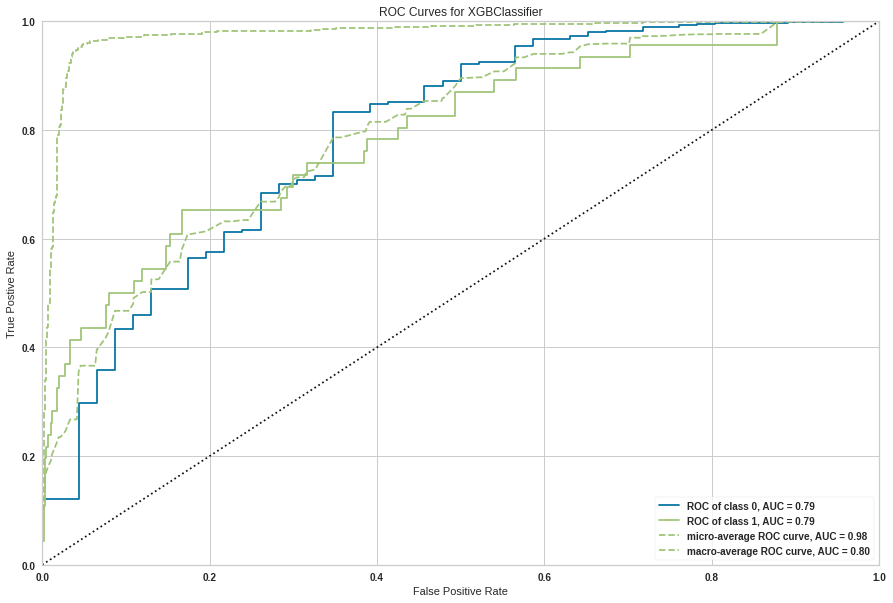

In [22]:
rocauc = ROCAUC(clf, size=(1080, 720))

rocauc.score(x_test, y_test)  
r = rocauc.poof()